In [120]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import plotly.graph_objects as go

In [100]:
demand = pd.read_excel('../dataset/a6_booster_delivery_planning.xlsx')
#events = pd.read_excel('../dataset/ariane_tracks_booster_container_1.0.xlsx')
events = pd.read_excel('../dataset/ariane_tracks_booster_container_2.0.xlsx')
events.drop(columns=['FM'],inplace=True)
dataset = pd.read_csv('../dataset/true_datas.csv')

states = ['A','B','C','D','E']
containers = ['SN'+str(i) for i in range(1,9)]
events['Entry'] = events['Entry'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))
events['Exit'] = events['Exit'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))


def days_spent_for_container(container):
    return({state:[(row[3] - row[2]).days for row in events.loc[(events['Container'] == container) & (events['Zone'] == state)].values] for state in states})

## I.   Data viz

In [101]:
print("demand shape :", demand.shape)
demand.head()

demand shape : (39, 2)


,Date,Config
0,2021-01-12,2
1,2021-08-24,4
2,2021-10-19,2
3,2022-01-28,2
4,2022-06-21,4


In [102]:
print("events shape :", events.shape)
events.head(50)

events shape : (353, 4)


,Container,Zone,Entry,Exit
0,SN6,A,2020-12-09,2020-12-24
1,SN6,B,2020-12-24,2020-12-29
2,SN6,C,2020-12-29,2020-12-30
3,SN6,D,2021-01-10,2021-01-12
4,SN6,E,2021-01-12,2021-01-27
5,SN6,D,2021-01-27,2021-01-29
6,SN6,C,2021-02-12,2021-02-13
7,SN6,B,2021-02-13,2021-02-18
8,SN5,A,2020-12-09,2020-12-24
9,SN5,B,2020-12-24,2020-12-29


## II.    correction algorithm

In [103]:
def fetch_same_date(data, entry):
    df = data.loc[data['Entry']==entry]
    if df.empty:
        return("ok", "ok", False)
    return(df['Entry'].iloc[0], df['Exit'].iloc[0], True)


def complete_steps(data):
    sorted_events = data.sort_values(['Exit'])
    cycle = ['A','B','C','D','E','D','C','B']
    values = []
    for container in containers:
        df = sorted_events.loc[(sorted_events['Container'] == container)]
        new_values = []
        step = 0
        for i,line in enumerate(df.values):

            while line[1] != cycle[step%8]:
                container_ = container
                state_ = cycle[step%8]
                entry_, exit_, result = fetch_same_date(data, df.values[i-1][3])
                print("corrupted_data")
                print(line)
                if not result:
                    entry_ = "ok"
                    exit_ = "ok"
                
                new_values.append([container_, state_, entry_, exit_])
                step+=1

            step+=1
            new_values.append(line)
        values.extend(new_values)
    
    return(pd.DataFrame(values, columns=['Container', 'Zone', 'Entry', 'Exit']))



def sanity_checking(data):
    data_ = data.explode('Container').sort_values(['Exit'])
    states = ['A','B','C','D','E','D','C','B']
    c=0
    for container in containers:
        df = data_.loc[data_['Container']==container]
        pointer=0
        for line in df.values:
            if line[1]!=states[pointer]:
                print(line)
                c+=1

            pointer+=1
            if pointer==8:
                pointer=0
    return(c)
data = complete_steps(events)
print("errors for containers :", sanity_checking(data))

corrupted_data
['SN5' 'A' Timestamp('2021-12-26 00:00:00')
 Timestamp('2022-01-10 00:00:00')]
errors for containers : 0


In [ ]:
#data.to_csv('../dataset/containers.csv',index=False)

## III. ML Model

In [104]:
dataset.head()

,Days,Inverted,PerfMean,PerfStd,EntryLoad,ExitLoad,EntryDemand,ExitDemand,Distance,ContainerQuantity,...,Entry_snowfall_sum,Entry_wind_speed_10m_max,Entry_wind_gusts_10m_max,Entry_wind_direction_10m_dominant,Exit_precipitation_sum,Exit_rain_sum,Exit_snowfall_sum,Exit_wind_speed_10m_max,Exit_wind_gusts_10m_max,Exit_wind_direction_10m_dominant
0,15.0,0.0,24.0,7.348469,0.0,0.0,0.0,0.0,0.00,2.0,...,0.0,26.980793,63.00,247.30750,0.0,0.0,0.0,21.897945,42.12,343.37125
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,9.70,2.0,...,0.0,21.897945,42.12,343.37125,0.0,0.0,0.0,21.897945,42.12,343.37125
2,5.0,0.0,5.0,0.000000,0.0,0.0,0.0,0.0,0.00,2.0,...,0.0,21.897945,42.12,343.37125,3.7,3.7,0.0,19.174856,36.36,242.80690
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,9.42,2.0,...,0.0,19.174856,36.36,242.80690,3.7,3.7,0.0,19.174856,36.36,242.80690
4,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.00,2.0,...,0.0,19.174856,36.36,242.80690,17.6,17.6,0.0,21.096123,39.96,251.11560


In [105]:
y = dataset.Days
X = dataset.drop(columns=['Days','Entry','Exit'])

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [125]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("mean squared error : ", mse)

mean squared error :  806.1940033535628


In [148]:
feature_rename = {
'Inverted':'Direction',
'PerfMean':'Average stage duration', 
'PerfStd':'Deviation of stage duration', 
'EntryLoad':'Entry load', 
'ExitLoad':'Exit load',
'EntryDemand':'Entry demand',
'ExitDemand':'Exit demand',
'Distance':'Distance',
'ContainerQuantity':'Container quantity',
'Stage':'Stage',
'Entry_Working_Day':'Entry working day',
'Exit_Working_Day':'Exit working day',
'Entry_precipitation_sum':'Entry precipitation',
'Entry_rain_sum':'Entry rain',
'Entry_snowfall_sum':'Entry snowfall',
'Entry_wind_speed_10m_max':'Entry wind speedx',
'Entry_wind_gusts_10m_max':'Entry wind gusts',
'Entry_wind_direction_10m_dominant':'Entry wind direction',
'Exit_precipitation_sum':'Exit precipitation',
'Exit_rain_sum':'Exit rain',
'Exit_snowfall_sum':'Exit snowfall',
'Exit_wind_speed_10m_max':'Exit wind speed',
'Exit_wind_gusts_10m_max':'Exit wind gusts',
'Exit_wind_direction_10m_dominant':'Exit wind direction',
}


importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns.map(feature_rename),
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
fig = go.Figure(go.Bar(
    x=feature_importance_df['Importance'],
    y=feature_importance_df['Feature'],
    orientation='h',
    marker=dict(color='#48AF8A')  # Using middle green color for bars
))

# Update layout
fig.update_layout(title='Feature Importance',
                  xaxis_title='Importance',
                  yaxis_title='Feature',
                  yaxis=dict(automargin=True),
                  height=800,
                 )
# Show plot
fig.show()

In [145]:
print(X.columns)
feature_rename = {
'Inverted':'Direction',
'PerfMean':'Average number of days it takes', 
'PerfStd':'PerfStd', 
'EntryLoad':'Entry load', 
'ExitLoad':'Exit load',
'EntryDemand':'Entry demand',
'ExitDemand':'Exit demand',
'Distance':'Distance',
'ContainerQuantity':'Container quantity',
'Stage':'Stage',
'Entry_Working_Day':'Entry working day',
'Exit_Working_Day':'Exit working day',
'Entry_precipitation_sum':'Entry precipitation',
'Entry_rain_sum':'Entry rain',
'Entry_snowfall_sum':'Entry snowfall',
'Entry_wind_speed_10m_max':'Entry wind speedx',
'Entry_wind_gusts_10m_max':'Entry wind gusts',
'Entry_wind_direction_10m_dominant':'Entry wind direction',
'Exit_precipitation_sum':'Exit precipitation',
'Exit_rain_sum':'Exit rain',
'Exit_snowfall_sum':'Exit snowfall',
'Exit_wind_speed_10m_max':'Exit wind speed',
'Exit_wind_gusts_10m_max':'Exit wind gusts',
'Exit_wind_direction_10m_dominant':'Exit wind direction',
}

Index(['Inverted', 'PerfMean', 'PerfStd', 'EntryLoad', 'ExitLoad',
       'EntryDemand', 'ExitDemand', 'Distance', 'ContainerQuantity', 'Stage',
       'Entry_Working_Day', 'Exit_Working_Day', 'Entry_precipitation_sum',
       'Entry_rain_sum', 'Entry_snowfall_sum', 'Entry_wind_speed_10m_max',
       'Entry_wind_gusts_10m_max', 'Entry_wind_direction_10m_dominant',
       'Exit_precipitation_sum', 'Exit_rain_sum', 'Exit_snowfall_sum',
       'Exit_wind_speed_10m_max', 'Exit_wind_gusts_10m_max',
       'Exit_wind_direction_10m_dominant'],
      dtype='object')


Epoch 1/20
8/8 [==============================] - 2s 55ms/step - loss: 39036.0234 - val_loss: 41582.7539
Epoch 2/20
8/8 [==============================] - 0s 10ms/step - loss: 33879.7422 - val_loss: 52384.6406
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 16405.3477 - val_loss: 345.1138
Epoch 4/20
8/8 [==============================] - 0s 13ms/step - loss: 14700.9980 - val_loss: 1090.6819
Epoch 5/20
8/8 [==============================] - 0s 20ms/step - loss: 9587.3848 - val_loss: 5204.8237
Epoch 6/20
8/8 [==============================] - 0s 19ms/step - loss: 4611.6694 - val_loss: 4619.6709
Epoch 7/20
8/8 [==============================] - 0s 26ms/step - loss: 3059.1565 - val_loss: 3196.1497
Epoch 8/20
8/8 [==============================] - 0s 11ms/step - loss: 1892.2528 - val_loss: 2195.1353
Epoch 9/20
8/8 [==============================] - 0s 15ms/step - loss: 1525.6367 - val_loss: 1717.1317
Epoch 10/20
8/8 [==============================] - 0s 17ms/step - los

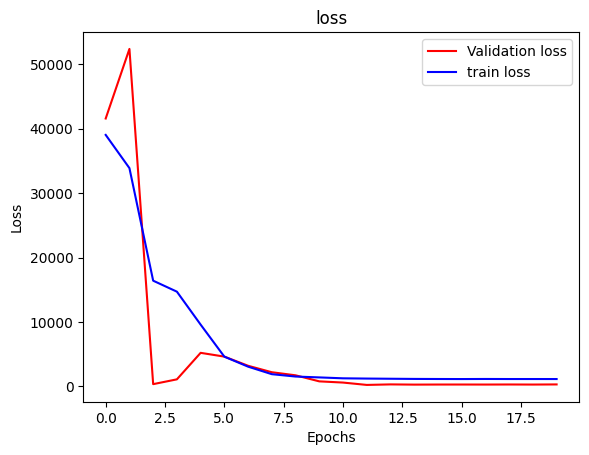

In [55]:
model_dl = tf.keras.Sequential([
    tf.keras.layers.Dense(124, input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
])

model_dl.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

history = model_dl.fit(
    X_train, 
    y_train, 
    epochs=20, 
    batch_size=32,
    validation_data=(X_test, y_test))
val_loss = history.history['val_loss']
train_loss = history.history['loss']
epochs = range(len(val_loss))
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, train_loss, 'b', label='train loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

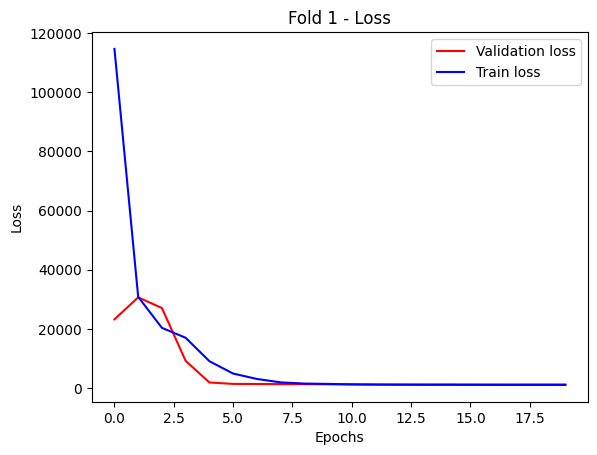

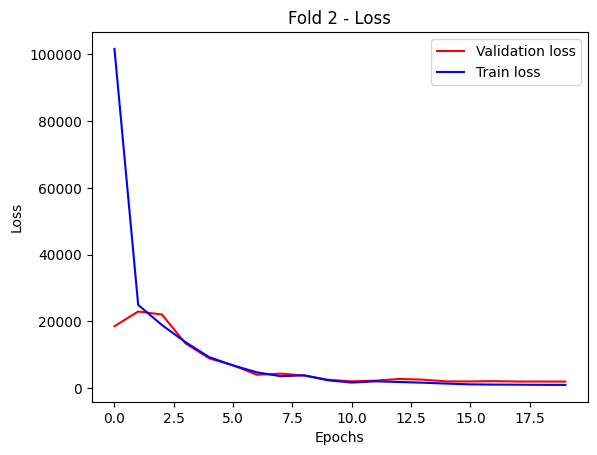

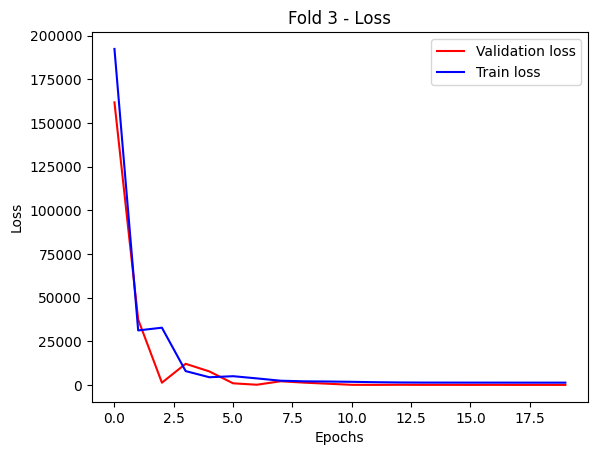

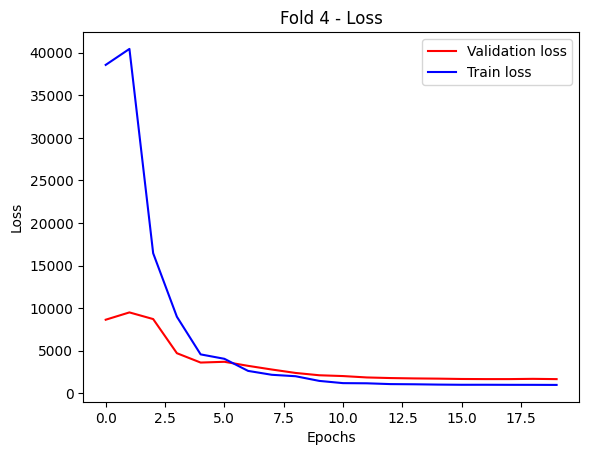

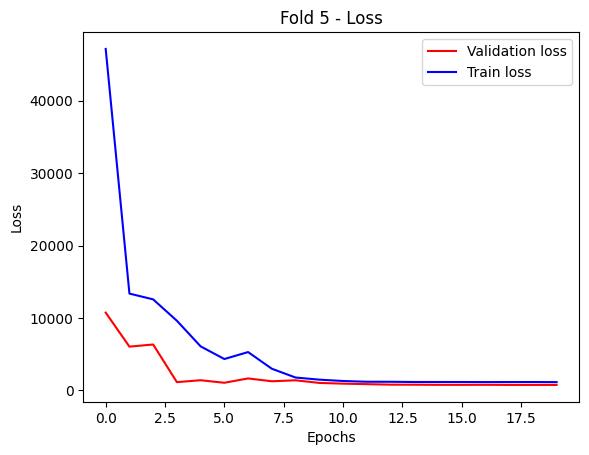

In [63]:
model_dl = tf.keras.Sequential([
    tf.keras.layers.Dense(124, input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
])

model_dl.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

kf = KFold(n_splits=5, shuffle=True)

fold = 1
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model_dl = tf.keras.Sequential([
    tf.keras.layers.Dense(124, input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    ])

    model_dl.compile(
    optimizer='adam',
    loss='mean_squared_error'
    )
    
    # Train the model
    history = model_dl.fit(
        X_train, 
        y_train, 
        epochs=20, 
        batch_size=32, 
        validation_data=(X_val, y_val),
        verbose=0
    )
    
    val_loss = history.history['val_loss']
    train_loss = history.history['loss']
    epochs = range(len(val_loss))
    
    plt.figure()
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.plot(epochs, train_loss, 'b', label='Train loss')
    plt.title(f'Fold {fold} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    fold += 1


In [94]:
import plotly.graph_objects as go

# Define colors
colors = ['#BFEEDB', '#8ED3AE', '#48AF8A', '#247B6C', '#CCE3F8', '#85C6EB', '#519EE5', '#283952']

# Data
containers = ['container '+str(i) for i in range(1,9)]
quantites_containers = list(data['Container'].value_counts())

# Create figure
fig = go.Figure(data=[go.Pie(labels=containers, values=quantites_containers)])

# Update layout
fig.update_traces(marker=dict(colors=colors))
fig.update_layout(title='Usage of containers')

# Show plot
fig.show()

In [98]:
def get_xgb_imp(xgb, feat_names):
    imp_vals = xgb.get_score(importance_type='gain')
    feats_imp = pd.DataFrame(imp_vals,index=np.arange(2)).T
    feats_imp.iloc[:,0]= feats_imp.index    
    feats_imp.columns=['feature','importance']
    feats_imp.sort_values('importance',inplace=True,ascending=False)
    feats_imp.reset_index(drop=True,inplace=True)
    return feats_imp

feature_importance_df = get_xgb_imp(xgb, X.columns)

AttributeError: module 'xgboost' has no attribute 'get_score'